In [1]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


# 학습 및 여러 환경을 설정해준다  

# GPU COUNT  : 사용하려는 GPU의 수

# IMAGES_PER_GPU : 한 Iterator당 GPU 하나당 학습할 IMAGE의 수

# IMAGE_MIN_DIM,IMAGE_MAX_DIM : 일반적으로 IMAGE의 크기와 같게 조정

# NUM_CLASSES : 1 + 분류하고자 하는 클래스의 수 만큼 지정

# STEP_PER_EPOCH : 1번의 EPOCH당 진행할 훈련의 수

In [2]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    # Learning rate
    LEARNING_RATE=0.005
    
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=20

In [3]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [4]:
class Dataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "Ship")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + '\\multi\\'
        annotations_dir = dataset_dir + '\\multi_labels\\'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4]
            image_id = image_id[:-4]
            # skip bad images
            #if image_id in ['00090']:
            #    continue
            # skip all images after 150 if we are building the train set
            #if is_train and int(image_id) >= 150:
            #    continue
            # skip all images before 150 if we are building the test/val set
            #if not is_train and int(image_id) < 150:
            #    continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + filename[:-4] +'.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)*2
            ymax = int(box.find('ymax').text)*2
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)*2
        height = int(root.find('.//size/height').text)*2
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('Ship'))
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [5]:
# prepare train set
train_set = Dataset()
train_set.load_dataset('D:/train', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = Dataset()
test_set.load_dataset('D:/test', is_train=True)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 243
Test: 61


In [6]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [7]:
#load the weights for COCO
model.load_weights('mask_rcnn_coco.h5',
                        by_name=True,
                        exclude=["mrcnn_class_logits",
                                "mrcnn_bbox_fc",
                                "mrcnn_bbox",
                                "mrcnn_mask"])

# 학습이 필요할 때만 (저장된 가중치 읽어올 때는 사용하지 않아도 됨)

In [8]:
## train heads with higher lr to speedup the learning
import keras.backend.tensorflow_backend as K
with K.tf.device('/gpu:0'):
    model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=100, layers='heads')
history = model.keras_model.history.history


Starting at epoch 0. LR=0.01

Checkpoint Path: ./maskrcnn_config20200815T1153\mask_rcnn_maskrcnn_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

C:\Users\sugo3\anaconda3\envs\jun\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\sugo3\anaconda3\envs\jun\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\sugo3\anaconda3\envs\jun\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/100
100/100 [==============================] - 407s 4s/step - loss: 3.2137 - rpn_class_loss: 0.2293 - rpn_bbox_loss: 1.5787 - mrcnn_class_loss: 0.1887 - mrcnn_bbox_loss: 0.7566 - mrcnn_mask_loss: 0.4603 - val_loss: 2.4341 - val_rpn_class_loss: 0.2013 - val_rpn_bbox_loss: 0.9385 - val_mrcnn_class_loss: 0.0846 - val_mrcnn_bbox_loss: 0.7226 - val_mrcnn_mask_loss: 0.4870

Epoch 2/100
100/100 [==============================] - 394s 4s/step - loss: 2.7256 - rpn_class_loss: 0.1651 - rpn_bbox_loss: 1.4224 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.4146 - val_loss: 2.5646 - val_rpn_class_loss: 0.1606 - val_rpn_bbox_loss: 1.1361 - val_mrcnn_class_loss: 0.1413 - val_mrcnn_bbox_loss: 0.6911 - val_mrcnn_mask_loss: 0.4356
Epoch 3/100
100/100 [==============================] - 396s 4s/step - loss: 2.6675 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 1.4983 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.5270 - mrcnn_mask_loss: 0.3807 - val_loss: 2.4267 - val_rpn

Epoch 42/100
100/100 [==============================] - 389s 4s/step - loss: 2.1785 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.3953 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.2943 - val_loss: 2.5198 - val_rpn_class_loss: 0.2239 - val_rpn_bbox_loss: 1.4058 - val_mrcnn_class_loss: 0.0197 - val_mrcnn_bbox_loss: 0.4999 - val_mrcnn_mask_loss: 0.3704
Epoch 43/100
100/100 [==============================] - 383s 4s/step - loss: 2.3283 - rpn_class_loss: 0.1292 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.3782 - mrcnn_mask_loss: 0.2936 - val_loss: 2.4219 - val_rpn_class_loss: 0.3151 - val_rpn_bbox_loss: 1.3513 - val_mrcnn_class_loss: 0.0106 - val_mrcnn_bbox_loss: 0.4049 - val_mrcnn_mask_loss: 0.3400
Epoch 44/100
100/100 [==============================] - 382s 4s/step - loss: 2.3246 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 1.5583 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.2772 - val_loss: 3.8419 - val_rpn_c

Epoch 64/100
100/100 [==============================] - 383s 4s/step - loss: 2.1310 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.4480 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.2559 - val_loss: 3.4571 - val_rpn_class_loss: 0.8315 - val_rpn_bbox_loss: 1.8665 - val_mrcnn_class_loss: 0.0120 - val_mrcnn_bbox_loss: 0.4079 - val_mrcnn_mask_loss: 0.3390
Epoch 65/100
100/100 [==============================] - 394s 4s/step - loss: 2.1731 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 1.4493 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2621 - val_loss: 3.3781 - val_rpn_class_loss: 0.7539 - val_rpn_bbox_loss: 1.6980 - val_mrcnn_class_loss: 0.0243 - val_mrcnn_bbox_loss: 0.5063 - val_mrcnn_mask_loss: 0.3954
Epoch 66/100
100/100 [==============================] - 381s 4s/step - loss: 2.4236 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.7858 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2706 - mrcnn_mask_loss: 0.2402 - val_loss: 5.0922 - val_rpn_c

Epoch 86/100
100/100 [==============================] - 377s 4s/step - loss: nan - rpn_class_loss: 1.3645 - rpn_bbox_loss: nan - mrcnn_class_loss: 12.7736 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0143 - val_loss: nan - val_rpn_class_loss: 1.3228 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 12.7764 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 87/100
100/100 [==============================] - 370s 4s/step - loss: nan - rpn_class_loss: 1.3705 - rpn_bbox_loss: nan - mrcnn_class_loss: 12.7736 - mrcnn_bbox_loss: 0.0157 - mrcnn_mask_loss: 0.0143 - val_loss: nan - val_rpn_class_loss: 1.3086 - val_rpn_bbox_loss: nan - val_mrcnn_class_loss: 12.7764 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


RuntimeError: Can't decrement id ref count (unable to extend file properly)

# 위 함수는 학습이 필요할 때만 실행

In [ ]:
import time
model_path = 'C:/Users/sugo3/OneDrive/바탕 화면/lungs/mask_rcnn_small_ship.h5'
model.keras_model.save_weights(model_path)

In [ ]:
#model_path = 'C:/Users/sugo3/OneDrive/바탕 화면/multi/mask_rcnn_multi.h5'
model_path = 'C:/Users/sugo3/OneDrive/바탕 화면/mask_rcnn_small_ship.h5'
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights('mask_rcnn_coco.h5',
                        by_name=True,
                        exclude=["mrcnn_class_logits",
                                "mrcnn_bbox_fc",
                                "mrcnn_bbox",
                                "mrcnn_mask"])
img = load_img("C:/Users/sugo3/OneDrive/바탕 화면/lungs_test/lung_image/8.dcm.png")
img = img_to_array(img)
print(len(img))
# detecting objects in the image
result= model.detect([img])

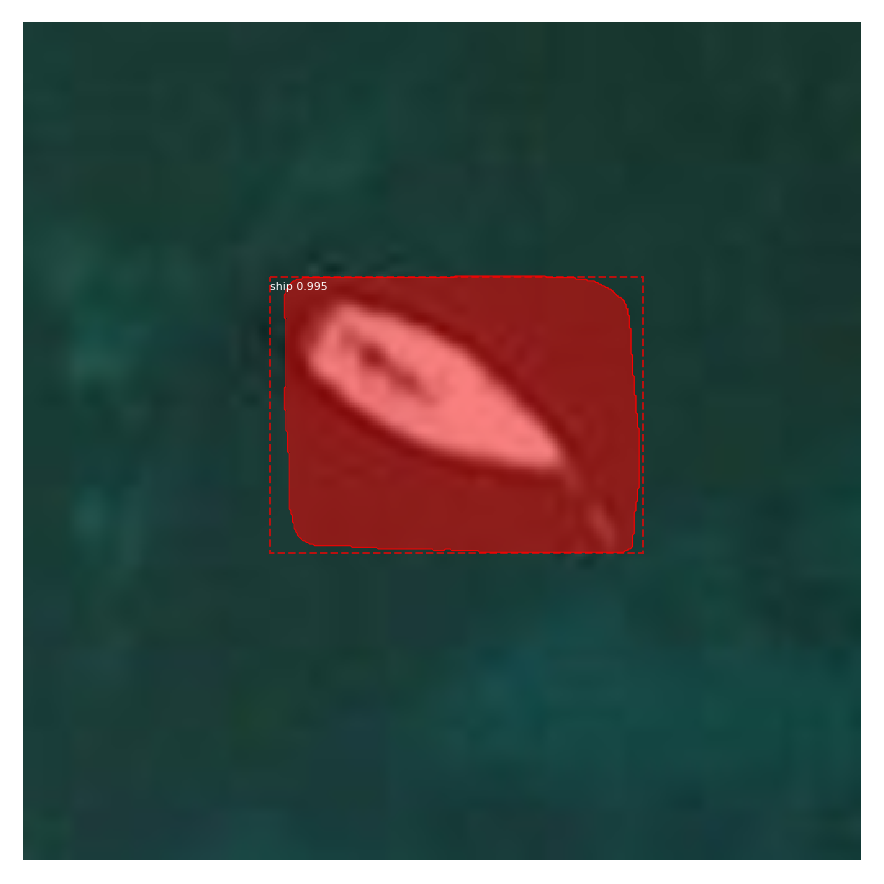

In [58]:
# Load else image from other diretory
import skimage
class_names=['ship']
IMAGE_DIR=os.path.join('C:/Users/sugo3/OneDrive/바탕 화면/test/images')
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=0)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'])

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10297618495149316310
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3045195776
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7259605570167376710
physical_device_desc: "device: 0, name: GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
